In [1]:
#Functions from lesson:
#1
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline
import numpy as np
#import pickle
import cv2
from scipy.ndimage.measurements import label
import glob
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier #try this
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import time
import random
import os
def load_pickle(file):
    with open(file+".pckl", mode='rb') as f:
        return pickle.load(f)
    
def save_pickle(filename,obj):
    print("saved as", filename + ".pckl")
    with open(filename+".pckl", mode='wb') as f:
        pickle.dump(obj, f)   

def convert_color(image, color_space='RGB2YCrCb',copy=False):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    elif copy: 
        return np.copy(image)   #??   
    else:
        return image


def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=[True,False,False],
                        spatial_feat=True, hist_feat=True, hog_feat=True, is_image=False):
    # Create a list to append feature vectors to
    features = []
    import sys
    # Iterate through the list of images
    
    for i,file in enumerate(imgs):
        
        file_features = []
        # Read in each one by one
        if is_image:
            image = file
        else:
            image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'   
        feature_image = convert_color(image,color_space,True)
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            hog_features = []
            for channel in range(feature_image.shape[2]):
                if hog_channel[channel]:
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)      
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        ss=sys.getsizeof(spatial_features)
        sh=sys.getsizeof(hist_features)
        sho=sys.getsizeof(hog_features)
        #print('\r', f"ss: {ss}, sh: {sh}, sho: {sho}, it: {i} / {len(imgs)} tots: {sys.getsizeof(features)} ", end='')
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)


def confirm_car(img,dist_pickle,spatial_feat=True, hist_feat=True, hog_feat=True):
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["X_scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    hog_channel = dist_pickle["hog_channel"]
    color_space = dist_pickle["color_space"]
    imgs=[img]
    f=extract_features(imgs, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat,is_image=True)
        
        
                # Scale features and make a prediction

 
    test_features = X_scaler.transform(f)

    #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))   
    
   
    test_prediction = svc.predict_proba(test_features)
    #print(test_prediction)
    return test_prediction[0][1]

        
        
     #       X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    #try:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop,xstart,xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins,color_space,hog_channel,one_row=False):
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64 #Should this still be 64??
    
    #To better fit with the analyse function thing, (it shows where the start should be)
    if one_row:
        ystop=ystart
    ystop=int(ystop+window*scale)
    
    
    box_list=[]
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)  
    
    imshape = ctrans_tosearch.shape
    if scale != 1:
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (int(imshape[1]//scale), int(imshape[0]//scale)))
        
    #if hog_channel[0]:
    ch1 = ctrans_tosearch[:,:,0]
    if hog_channel[1]:
        ch2 = ctrans_tosearch[:,:,1]
    if hog_channel[2]:
        ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    

    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    if one_row:
        nysteps=1
    else:
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    
    if hog_channel[0]:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel[1]:
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel[2]:
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1=[]
            hog_feat2=[]
            hog_feat3=[]
            if hog_channel[0]:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel[1]:
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel[2]:
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append([(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)])
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return box_list##draw_img, 




# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#Add a heatmap based on the boxes
def add_heat(heatmap, bbox_list,heat=1):
    # Iterate through list of bboxes    
    for box in bbox_list:
        #print(box[0][1],box[1][1], box[0][0],box[1][0])
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += heat

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

#keep just the parts where we have more than one box
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def decrease_threshold(heatmap,factor=1,coolness=0,kugleblitz=255):
    # Zero out pixels below the threshold
    heatmap[heatmap > 0] *= factor #-= heat
    heatmap[heatmap > 0] -= coolness #-= heat
    #heatmap[heatmap > kugleblitz] = kugleblitz
    heatmap[heatmap < 0] = 0
  #  print(np.min(heatmap))
   # print(np.max(heatmap))
    
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    all_bbox=[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #if the box is too small remove it
        if np.max(nonzerox)-np.min(nonzerox) > 10 and np.max(nonzeroy)-np.min(nonzeroy) > 10:
            all_bbox.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 2)
    # Return the image
    return img,all_bbox

def get_heatmap_accuracy(y_start_stop, svc, X_scaler, orient,pix_per_cell, cell_per_block, 
                         spatial_size, hist_bins,color_space,hog_channel,scale = 1.5):
    images = sorted(glob.glob('test_images/test*.jpg'))
    bimages = sorted(glob.glob('test_images/btest*.jpg'))
    totalcorr=0
    for index in range(len(images)):
        image = mpimg.imread(images[index])
        bimage = mpimg.imread(bimages[index])
        draw_image = np.copy(image)
        bimage=np.copy(bimage[:,:,0]).astype(np.float32)/255
        bimage[bimage>100]=255

        # Uncomment the following line if you extracted training
        # data from .png images (scaled 0 to 1 by mpimg) and the
        # image you are searching is a .jpg (scaled 0 to 255)
        image = image.astype(np.float32)/255
        

        hot_windows = find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel)

        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

        heatmap = np.zeros_like(image[:,:,0])
        heatmap = add_heat(heatmap, hot_windows)

        heatmap_img = apply_threshold(heatmap, 1)
        heatmap_binary=heatmap_img
        heatmap_binary[heatmap_binary>0]=255
        shape=np.shape(heatmap_binary)
        totalcorr+=sum(sum(heatmap_binary==bimage))/(shape[0]*shape[1])

    totalcorr/=len(images)
    return totalcorr


()
data/vehicles/KITTI_extracted/173.png


Text(0.5,1,'Not Car HOG')

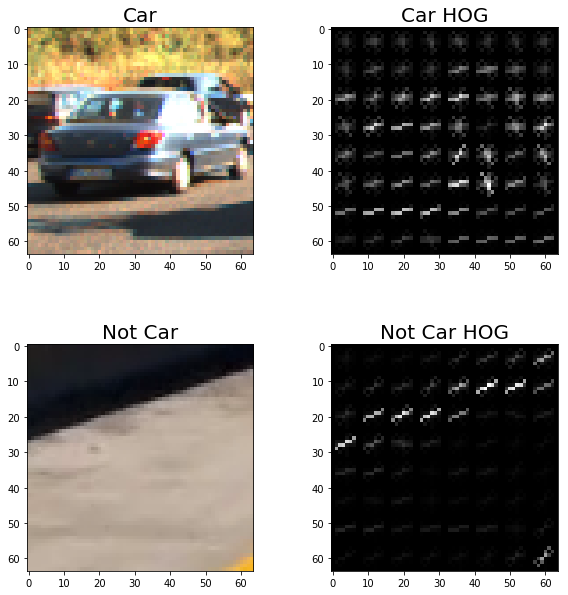

In [2]:
#2
#Get images etc for the report
# Divide up into cars and notcars

cars = glob.glob('data/vehicles/**/*.png')
notcars = glob.glob('data/non-vehicles/**/*.png')


carIndex=np.random.randint(len(cars))
notcarIndex=np.random.randint(len(notcars))
print(np.shape(cars[carIndex]))
print(cars[carIndex])

carExampleImage=mpimg.imread(cars[carIndex])
notExampleImage=mpimg.imread(notcars[notcarIndex])      

#Then some images and thier Hog features,

_, carhogimage = get_hog_features(carExampleImage[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
_, nothogimage = get_hog_features(notExampleImage[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(carExampleImage)
ax1.set_title('Car', fontsize=20)
ax2.imshow(carhogimage, cmap='gray')
ax2.set_title('Car HOG', fontsize=20)
ax3.imshow(notExampleImage)
ax3.set_title('Not Car', fontsize=20)
ax4.imshow(nothogimage, cmap='gray')
ax4.set_title('Not Car HOG', fontsize=20)

In [20]:
#3

#Get features
#Try using a Genetic algorithm or something to find this
### TODO: Tweak these parameters and see how the results change.
        
def get_feature_and_train(color_space = 'YUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
                                    orient = 11,  # HOG orientations
                                    pix_per_cell = 16, # HOG pixels per cell
                                    cell_per_block = 4, # HOG cells per block
                                    hog_channel1 = False, #2#"ALL" # Can be 0, 1, 2, or "ALL"
                                    hog_channel2 = False,
                                    hog_channel3 = True,
                                    spatial_size = (16, 16), # Spatial binning dimensions
                                    hist_bins = 16,    # Number of histogram bins
                                    spatial_feat = True, # Spatial features on or off
                                    hist_feat = True, # Histogram features on or off
                                    hog_feat = True, # HOG features on or off
                                    sample_size=-1,
                                    y_start_stop = [400,660]):# Min and max in y to search in slide_window()
                                 
    cars = glob.glob('data/vehicles/**/*.png')
    notcars = glob.glob('data/non-vehicles/**/*.png')

    hog_channel = [hog_channel1,hog_channel2,hog_channel3]
    t1=time.time()
    if sample_size > 0:
        cars=np.random.choice(cars,sample_size, replace=False)
        notcars=np.random.choice(notcars,sample_size, replace=False)
    
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    #try:
    X_scaler = StandardScaler().fit(X)
    #except
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
 
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

   # print('Using:',orient,'orientations',pix_per_cell,
   #     'pixels per cell and', cell_per_block,'cells per block')
   # print('Feature vector length:', len(X_train[0]))


    #Train classifier
   
    # Use a linear SVC 
    svc = MLPClassifier()#LinearSVC(C=1.2)

    t2=time.time()
    svc.fit(X_train, y_train)
    t3 = time.time()
    total_time=t3-t1

    #print(round(total_time, 2), " to run all")
    #print(round(t3-t2, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    score=svc.score(X_test, y_test)
    heat_score=get_heatmap_accuracy(y_start_stop, svc, X_scaler, orient, 
                      pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel)
    #print('Test Accuracy of SVC = ', round(score, 4))
    #print("heatmap accuracy: ", heat_score)
    # Check the prediction time for a single sample
    t=time.time()
    return svc,X_scaler, score, heat_score ,total_time, t3-t2

In [21]:
#4


    # Check the training time for the SVC
    #t2=time.time()
    #svc.fit(X_train, y_train)
    #t3 = time.time()
    #total_time=t3-t1
    #print(round(total_time, 2), " to run all")
    #print(round(t3-t2, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    #score=svc.score(X_test, y_test)
    #heat_score=get_heatmap_accuracy(y_start_stop, svc, X_scaler, orient, 
    #                  pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel)
    #print('Test Accuracy of SVC = ', round(score, 4))
    #print("heatmap accuracy: ", heat_score)
    # Check the prediction time for a single sample
    #t=time.time()
    #return score, heat_score ,total_time, t3-t2

table=[]
row=["color_space","orient","pix_per_cell","cell_per_block","hog1","hog2","hog3",
     "spatial_size","spatial_feat","hist_feat","hog_feat","score","heat_score","mean","train_time","total_time"]
table.append(row)

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel1 = False #2#"ALL" # Can be 0, 1, 2, or "ALL"
hog_channel2 = False
hog_channel3 = True
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400,660]
sample_size=2000
for color_space in ['HSV','YUV','HLS']:
    for orient in [11,12]:
        for pix_per_cell in [12,16]:
            for cell_per_block in [2,4]:
                for hist_bins in [16,20]:
                    for hog_channel1 in [False,True]:
                        for hog_channel2 in [False,True]:
                            for hog_channel3 in [False,True]:
                                _,_,score, heat_score ,total_time,train_time=get_feature_and_train(color_space, orient,  pix_per_cell,cell_per_block, hog_channel1,hog_channel2,
                                            hog_channel3,spatial_size,  hist_bins, spatial_feat,hist_feat, hog_feat,sample_size)
                                row=[color_space,orient,pix_per_cell,cell_per_block,hog_channel1,hog_channel2,hog_channel3,
                                     spatial_size,spatial_feat,hist_feat,hog_feat,round(score, 4),round(heat_score, 4),
                                     round((score+heat_score)/2, 4),round(train_time, 4),round(total_time, 4)]
                                table.append(row)
                    print("hog done")

    print("color done")

from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(table, tablefmt='html')))

12
12


KeyboardInterrupt: 

In [ ]:
#Train with good parameters we found above!

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel1 = True #2#"ALL" # Can be 0, 1, 2, or "ALL"
hog_channel2 = True
hog_channel3 = True
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400,660]

#color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 9  # HOG orientations
#pix_per_cell = 4 # HOG pixels per cell
#cell_per_block = 4 # HOG cells per block
#hog_channel1 = True #2#"ALL" # Can be 0, 1, 2, or "ALL"
#hog_channel2 = True
#hog_channel3 = True
#spatial_size = (32, 32) # Spatial binning dimensions
#hist_bins = 16    # Number of histogram bins
#spatial_feat = True # Spatial features on or off
#hist_feat = True # Histogram features on or off
#hog_feat = True # HOG features on or off


#From the qa video
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
#pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
#hog_channel1 = True #2#"ALL" # Can be 0, 1, 2, or "ALL"
#hog_channel2 = True
#hog_channel3 = Trueycrbr
#spatial_size = (32, 32) # Spatial binning dimensions
#hist_bins = 32    # Number of histogram bins
#spatial_feat = True # Spatial features on or off
#hist_feat = True # Histogram features on or off
#hog_feat = True # HOG features on or off




svc,X_scaler,score, heat_score ,total_time,train_time=get_feature_and_train(color_space, orient, pix_per_cell,
                                    cell_per_block, hog_channel1,hog_channel2, hog_channel3,spatial_size, 
                                    hist_bins, spatial_feat,hist_feat, hog_feat,sample_size=1000)
#Now svc is a great model, so save it
print(f"score: {score}, heat score: {heat_score}, tot time: {total_time}, train time: {train_time}")


            
            
save_pickle("model_qa_new2",{"svc":svc,
                     "X_scaler":X_scaler,
                     "orient":orient,
                     "pix_per_cell":pix_per_cell,
                     "cell_per_block":cell_per_block,
                     "spatial_size":spatial_size,
                     "hist_bins":hist_bins,
                     "hog_channel":[hog_channel1,hog_channel2,hog_channel3],
                    "color_space":color_space
                    })

96.0


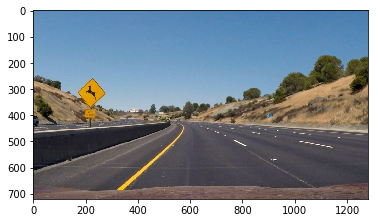

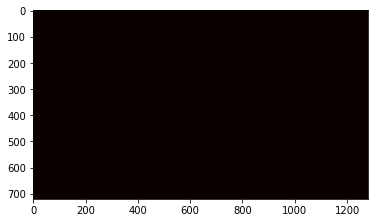

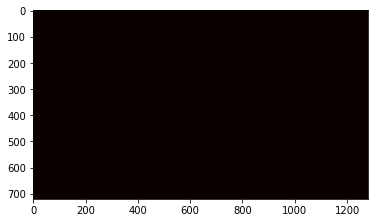

0.999778645833


In [10]:
#try the classifier with just images before video
images = sorted(glob.glob('test_images/test*.jpg'))
%matplotlib inline
index=np.random.randint(len(images))
image = mpimg.imread(images[index])

draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255
y_start_stop = [400,660]
scale = 1.5



dist_pickle=load_pickle("model_qa_new2")
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hog_channel = dist_pickle["hog_channel"]
color_space = dist_pickle["color_space"]
scale = 1.5
print(64*scale)
xstart=0
xstop=image.shape[1]
hot_windows = find_cars(image, y_start_stop[0], y_start_stop[1],xstart,xstop, scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
for window in hot_windows:
    print(window[1][0]-window[0][0])
    print(window[1][1]-window[0][1])
plt.imshow(window_img)
plt.show()
#Do the heatmap stuff
heatmap = np.zeros_like(image[:,:,0])
heatmap = add_heat(heatmap, hot_windows)
plt.imshow(heatmap, cmap='hot')
plt.show()
heatmap_img = apply_threshold(heatmap, 1)

plt.imshow(heatmap_img, cmap='hot')
plt.show()



bimages = sorted(glob.glob('test_images/btest*.jpg'))
bimage = mpimg.imread(bimages[index])
draw_image = np.copy(image)
bimage=np.copy(bimage[:,:,0]).astype(np.float32)/255
bimage[bimage>100]=255
heatmap_binary=heatmap_img
heatmap_binary[heatmap_binary>0]=255
shape=np.shape(heatmap_binary)
print(sum(sum(heatmap_binary==bimage))/(shape[0]*shape[1]))

In [11]:
#try the classifier with just images before video
images = sorted(glob.glob('test_images/test*.jpg'))


dist_pickle=load_pickle("model_qa_new")
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
hog_channel = dist_pickle["hog_channel"]
color_space = dist_pickle["color_space"]



#draw_image = np.copy(image)
bimages = sorted(glob.glob('test_images/btest*.jpg'))
bimagesimages=[]
for imgpath in bimages:
    bimage = mpimg.imread(imgpath)
    bimage=np.copy(bimage[:,:,0]).astype(np.float32)/255
    bimage[bimage>100]=255
    bimagesimages.append(bimage)

ylen = bimagesimages[0].shape[0]  
table=[]
table.append(["start","scale","match","false","boxes","time"])
for scale in np.arange(.1,4,0.1):
    t1 = time.time()
    print(scale)
    #ystart=random.randint(300,ylen-100)
    
    #scale = random.uniform(0.5,2)
    
    for ystart in range(300,ylen,10):
        y_start_stop = [ystart,ylen]
        
        nWindows=0
        heatscore=0
        heatscorefalse=0
        bflag=False
        for i, image_a in enumerate(images):
            image =  mpimg.imread(image_a).astype(np.float32)/255
            bimage=bimagesimages[i]
            try:
                hot_windows = find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, 
                          pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel,one_row=True)
            except:
                bflag=True
                break
            heatmap = np.zeros_like(image[:,:,0])
            heatmap = add_heat(heatmap, hot_windows)
            heatmap[heatmap>0]=255
            shape=np.shape(heatmap)
            #how much of what we want is good
            truehotindexes = np.array(bimage[y_start_stop[0]:y_start_stop[0]+int(64*scale),:]>0)
            hotindexes = np.array(heatmap[y_start_stop[0]:y_start_stop[0]+int(64*scale),:]>0)
            deno =(sum(sum(truehotindexes)))
            if deno!=0:
                heatscore += sum(sum(truehotindexes&hotindexes))/deno
            #how much false positive?
            heatscorefalse += sum(sum(np.logical_not(truehotindexes)&hotindexes))/(sum(sum(np.logical_not(truehotindexes))))
            t2 = time.time()
            total_time=t2-t1
            nWindows += len(hot_windows)
        if bflag:
            break
        #if nWindows > 0:
        heatscore/=len(images)
        heatscorefalse/=len(images)
        table.append([y_start_stop[0],scale,heatscore,heatscorefalse,nWindows,total_time])

#window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
#from mpl_toolkits.mplot3d import Axes3D
#import scipy.linalg
#Xdata=np.array(table)[1:,0].astype(float)
#print(Xdata)
#Ydata=np.array(table)[1:,1].astype(float)
#print(Ydata)
#Zdata=np.array(table)[1:,2].astype(float)
#print(Zdata)
#data=np.array((Xdata,Ydata,Zdata))
#print(data)

#X,Y = np.meshgrid(np.unique(X), np.unique(Y))

#XX = X.flatten()
#YY = Y.flatten()
# best-fit quadratic curve
#A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
#C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])

# evaluate it on a grid
#Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#surf = ax.scatter(Xdata, Ydata,Zdata)

#from IPython.display import HTML, display
#import tabulate

#display(HTML(tabulate.tabulate(table, tablefmt='html')))
save_pickle("scaletable2",{"table":table})

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
saved as scaletable2.pckl


In [28]:
def add_text(img, strings):
    for i, string in enumerate(strings):
        img=cv2.putText(img, string,(50,50+i*50),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,0),2)
    return img

def process_image(input_image,dist_pickle,heatmap,car_tracker,cnt):
    t1 = time.time()
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["X_scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    hog_channel = dist_pickle["hog_channel"]
    color_space = dist_pickle["color_space"]
    #find hot windows:
    y_start_stop = [0,1]
    hot_windows = []
    t2 = time.time()
    xstart=input_image.shape[1]//2
    xstop=input_image.shape[1]
    #for i,scale,y_start_stop in enumerate([1,1.5]):#0.8,1,1.2,1.3,1.4,1.5,1.6]):
    for scale,y_start_stop in [[1,[400,500]],[1.5,[350,450]],[1.6,[350,450]]]:#0.8,1,1.2,1.3,1.4,1.5,1.6]):
        hw=find_cars(input_image, y_start_stop[0], y_start_stop[1], xstart,xstop,scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space,hog_channel)
        if hw:
            #cnt[i]+= len(hw)
            #print(cnt)
            hot_windows.append(hw)
    t3 = time.time()
    hot_windows = [item for sublist in hot_windows for item in sublist] 
    #if hot_windows:
    #    hot_windows=np.concatenate(hot_windows)
    heatmap = add_heat(heatmap, hot_windows,4)
  #  deno=sum(sum(heatmap))/(heatmap.shape[0]*heatmap.shape[1])
   # if deno < 2:
   #     deno=2
    #print(deno)
    #if deno>0:
    heatmap = decrease_threshold(heatmap,0.9,1) #This will decay the heatmap3/deno
    heatmap_img = apply_threshold(np.copy(heatmap),30)
    #output_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=6) 
    x_offset=800
    y_offset=100
    #heatmap = np.zeros_like(image[:,:,0])
    labels = label(heatmap_img)
    
    t4 = time.time()
    result_image, all_bbox = draw_labeled_bboxes(np.copy(input_image), labels)
    
    car_tracker.update_frame(input_image)
    for bbox in all_bbox:
        car_tracker.update_cars(bbox)
    t5 = time.time()
    car_boxes = car_tracker.get_car_boxes()
    #result_image=draw_boxes(result_image, car_boxes, color=(255, 255, 255), thick=6)
    for box in car_boxes:
        if box[2] > 0.95:
            color = (0,255,0)
        elif box[2] > 0.85:
            color = (0,0,200)
        elif box[2] > 0.75:
            color = (150,0,0)
        elif box[2] > 0.65:
            color = (100,100,100)
        else:
            color = (0,0,0)
        cv2.circle(result_image, (int(box[0][0]),int(box[0][1])), int(box[1]), color=color, thickness=6)
    t6 = time.time()
    tmp = cv2.cvtColor(heatmap, cv2.COLOR_GRAY2RGB)
    tmp=draw_boxes(tmp, hot_windows, color=(0, 0, 255), thick=6)
    binary_image = cv2.resize(tmp, (400,200))
    result_image[y_offset:y_offset+200, x_offset:x_offset+400] = binary_image
    t7 = time.time()
    #add text:
    result_image=add_text(result_image, car_tracker.get_text())
    #print(f"t7 {t7-t6} t6 {t6-t5} t5 {t5-t4} t4 {t4-t3} t3 {t3-t2} t2 {t2-t1}")
    #display.display(result_image)
    return result_image

In [29]:
class carTracker:
    def __init__(self,dist_pickle,image):
        #print("intit track")
        self.tot_item_found=0
        self.current_car_count=0
        self.cars={}
        self.dist_pickle=dist_pickle
        self.image=image
        
    def get_image():
        return self.image
    
    def add_car(self,bbox):
        # pos is in (x,y)
        self.tot_item_found +=1
        new_id= self.tot_item_found
        #print(f"new car {new_id}")
        self.cars[new_id]=car(new_id, bbox,self.dist_pickle)
        
    def update_frame(self,image):

        #this updates all that need update each frame
        self.image=image
        delete_items=[]
        for carid, data in self.cars.items():
            data.probability-=0.1
            if data.probability <= 0:
                delete_items.append(carid)
            data.update_car_frame(self.image)
            data.car_taken=False
        for carid in delete_items:
            #print(f"delete {self.cars[carid].id}")
            del self.cars[carid]
            
    def update_cars(self,bbox):
        #print("get car")
        '''Returns all car candidates in the box with a distance'''
        #found_cars=[]
        best_car=None
        best_car_dist=10000000
        bboxpos=((bbox[1][0]+bbox[0][0])/2,(bbox[1][1]+bbox[0][1])/2)
        #size=((bbox[1][0]-bbox[0][0]+bbox[1][1]-bbox[0][1])/2)
        for carid, data in self.cars.items():
            dist=abs(bboxpos[0]-data.pos[0])+abs(bboxpos[1]-data.pos[1])
            
            #Todo, make size smaller and move in direction of movement.
            if not data.car_taken and dist < data.size/2 and dist < best_car_dist:
                #print("insidebox")
                best_car=(carid,bbox)
                #found_cars.append(carid,dist)
            #if bbox[1][0] > data.pos[0] > bbox[0][0] and bbox[1][1] > data.pos[1] > bbox[0][1]:
            #    
        if best_car:
            self.cars[best_car[0]].update(best_car[1])
        else:
            self.add_car(bbox)
        return best_car
    
    
    def update_cars2(self,bbox_list):
        #print("get car")
        '''Returns all car candidates in the box with a distance'''
        #found_cars=[]
        best_car=None
        best_car_dist=10000000
        #for carid, data in self.cars.items():
       #     for bbox in bbox_list:
        
        
        
        bboxpos=((bbox[1][0]+bbox[0][0])/2,(bbox[1][1]+bbox[0][1])/2)
        #size=((bbox[1][0]-bbox[0][0]+bbox[1][1]-bbox[0][1])/2)
        for carid, data in self.cars.items():
            dist=abs(bboxpos[0]-data.pos[0])+abs(bboxpos[1]-data.pos[1])
            
            #Todo, make size smaller and move in direction of movement.
            if not data.car_taken and dist < data.size/2 and dist < best_car_dist:
                #print("insidebox")
                best_car=(carid,bbox)
                #found_cars.append(carid,dist)
            #if bbox[1][0] > data.pos[0] > bbox[0][0] and bbox[1][1] > data.pos[1] > bbox[0][1]:
            #    
        if best_car:
            self.cars[best_car[0]].update(best_car[1])
        else:
            self.add_car(bbox)
        return best_car
    
    def get_text(self):
        output=[]
        for _, data in self.cars.items():
            output.append(data.who_are_you_mr_car())
        return output
    
    def get_car_boxes(self):
        boxes=[]
        for _, data in self.cars.items():
            if data.probability > 0.8:
                boxes.append((data.pos,data.size,data.probability))#data.carbox)
        return boxes
    
    class line():
        #To be implemented
        pass    
    
    
        
class car(carTracker): 
    def __init__(self,new_id,bbox,dist_pickle):
        #print("initcar")

        # size is the avrage distance to borders
   
        self.id=new_id
        self.pos=((bbox[1][0]+bbox[0][0])/2,(bbox[1][1]+bbox[0][1])/2)
        self.size=((bbox[1][0]-bbox[0][0]+bbox[1][1]-bbox[0][1])/4)
        self.carbox=bbox
        self.probability=0.2 #probability it really is a car
        self.rel_speed=(0,0)
        self.alive_frame_counter=0
        self.car_taken=True
        self.dist_pickle = dist_pickle
        self.image=[]#super()get[]#cv2.resize(img, (64,64))

    #This update only when found
    def update(self,bbox):

        newpos=((bbox[1][0]+bbox[0][0])/2,(bbox[1][1]+bbox[0][1])/2)
        dist=(newpos[0]-self.pos[0],newpos[1]-self.pos[1])
        phi=0.8
        self.rel_speed=(self.rel_speed[0]*phi+dist[0]*(1-phi),
                        self.rel_speed[1]*phi+dist[1]*(1-phi))#avg.pixels per frame 
        self.size=((bbox[1][0]-bbox[0][0]+bbox[1][1]-bbox[0][1])/4)
        self.pos=newpos#((bbox[1][0]+bbox[0][0])/2,(bbox[1][1]+bbox[0][1])/2)
        self.alive_frame_counter+=1
        
        car_img_proba=confirm_car(self.image,self.dist_pickle)
        self.probability+=.1+(car_img_proba-.5)
        if self.probability<0.5:
            self.probability+=0.2
        elif car_img_proba>.8:
            self.probability+=0.2#(car_img_proba/10)*1.5 #
        #elif car_img_proba<.3:
        #    self.probability-=0.2
        else:
            self.probability+=0.075
       # ne=confirm_car(self.image,self.dist_pickle)
        #print(ne)
        #if ne[0]==1:
        #    print("car")
        #else:
        #    print("nocar")
        if self.probability >= 1:
            self.probability=1
            
        if(car_img_proba>.9): ##This is wrong
            path=f"runimg/car/test_{self.id}-{self.alive_frame_counter}-{int(car_img_proba*100)}.png"
        else:
            path=f"runimg/nocar/test_{self.id}-{self.alive_frame_counter}-{int(car_img_proba*100)}.png"
        #print(path)
        mpimg.imsave(path,self.image)


        #print(f"hi, my name is {self.id}. speed: {self.rel_speed} , pos {self.pos}"+
        #      f"Iam {self. alive_frame_counter} frames old, and my probs is {self.probability}")
        

        #self.image=super().get_image().imagecv2.resize(img, (64,64))

    def who_are_you_mr_car(self):
        speed=np.sqrt(self.rel_speed[0]**2+self.rel_speed[1]**2)
        return (f"car{self.id}. v: {speed:.2f}, pos ({self.pos[0]:.1f},{self.pos[1]:.1f})"+
              f"age: {self. alive_frame_counter}, prob: {self.probability*100:.1f}%")

    #This updates every frame.. another name?
    def update_car_frame(self,image):
        self.pos=(self.pos[0]+self.rel_speed[0],self.pos[1]+self.rel_speed[1])
        self.pos[0]+self.size


        if np.shape(image)[0]>0:
            topx=np.clip(int(self.pos[1]+self.size), 10, np.shape(image)[0]-1)
            lowx=np.clip(int(self.pos[1]-self.size), 0, topx-10)
            topy=np.clip(int(self.pos[0]+self.size), 10, np.shape(image)[1]-1)
            lowy=np.clip(int(self.pos[0]-self.size), 0, topy-10)
            #print(topx)
            #print(lowx)
            #print(topy)
            #print(lowy)
            #print(np.shape(image))
            self.image=cv2.resize(image[lowx:topx,lowy:topy,:], (64,64)).astype(np.float32)/255
    
            

        

In [31]:
#just used to get the size of the video.. could be done better?
image = mpimg.imread("test_images/test1.jpg")
image = image.astype(np.float32)/255

cnt=[0,0,0,0,0,0,0,0]
dist_pickle=load_pickle("model_qa_new2")
print(dist_pickle)
car_tracker=carTracker(dist_pickle,np.zeros_like(image))
heatmap = np.zeros_like(image[:,:,0])

video_output = 'test_videos_output/project_video_long.mp4'
video_input = VideoFileClip("project_video.mp4")#.subclip(10,20)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
video = video_input.fl_image(lambda img: process_image(img,dist_pickle,heatmap,car_tracker,cnt)) #NOTE: this function expects color images!!
video.write_videofile(video_output, audio=False)

#HTML("""
#<video width="960" height="540" controls>
#  <source src="{0}">
#</video>
#""".format(video))

{'svc': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False), 'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'orient': 9, 'pix_per_cell': 16, 'cell_per_block': 2, 'spatial_size': (16, 16), 'hist_bins': 16, 'hog_channel': [True, True, True], 'color_space': 'YCrCb'}
[MoviePy] >>>> Building video test_videos_output/project_video_long.mp4
[MoviePy] Writing video test_videos_output/project_video_long.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<23:45,  1.13s/it]

  0%|          | 2/1261 [00:02<24:19,  1.16s/it]

  0%|          | 3/1261 [00:03<24:42,  1.18s/it]

  0%|          | 4/1261 [00:04<23:25,  1.12s/it]

  0%|          | 5/1261 [00:05<22:40,  1.08s/it]

  0%|          | 6/1261 [00:06<23:58,  1.15s/it]

  1%|          | 7/1261 [00:08<24:41,  1.18s/it]

  1%|          | 8/1261 [00:09<23:54,  1.14s/it]

  1%|          | 9/1261 [00:10<22:01,  1.06s/it]

  1%|          | 10/1261 [00:10<20:56,  1.00s/it]

  1%|          | 11/1261 [00:12<22:31,  1.08s/it]

  1%|          | 12/1261 [00:13<22:21,  1.07s/it]

  1%|          | 13/1261 [00:14<23:07,  1.11s/it]

  1%|          | 14/1261 [00:15<20:34,  1.01it/s]

  1%|          | 15/1261 [00:16<20:09,  1.03it/s]

  1%|▏         | 16/1261 [00:17<21:54,  1.06s/it]

  1%|▏         | 17/1261 [00:18<24:18,  1.17s/it]

  1%|▏         | 18/1261 [00:20<25:04,  1.21s/it]

  2%|▏         | 19/1261 [00:21<25:03,  1.21s/i

 11%|█▏        | 143/1261 [02:27<16:28,  1.13it/s]

 11%|█▏        | 144/1261 [02:28<16:15,  1.15it/s]

 11%|█▏        | 145/1261 [02:29<15:37,  1.19it/s]

 12%|█▏        | 146/1261 [02:29<15:17,  1.22it/s]

 12%|█▏        | 147/1261 [02:30<15:16,  1.22it/s]

 12%|█▏        | 148/1261 [02:31<15:34,  1.19it/s]

 12%|█▏        | 149/1261 [02:32<16:05,  1.15it/s]

 12%|█▏        | 150/1261 [02:33<15:35,  1.19it/s]

 12%|█▏        | 151/1261 [02:34<15:12,  1.22it/s]

 12%|█▏        | 152/1261 [02:35<15:16,  1.21it/s]

 12%|█▏        | 153/1261 [02:35<15:23,  1.20it/s]

 12%|█▏        | 154/1261 [02:37<17:07,  1.08it/s]

 12%|█▏        | 155/1261 [02:38<20:05,  1.09s/it]

 12%|█▏        | 156/1261 [02:39<20:58,  1.14s/it]

 12%|█▏        | 157/1261 [02:40<21:10,  1.15s/it]

 13%|█▎        | 158/1261 [02:42<22:21,  1.22s/it]

 13%|█▎        | 159/1261 [02:43<21:31,  1.17s/it]

 13%|█▎        | 160/1261 [02:44<19:51,  1.08s/it]

 13%|█▎        | 161/1261 [02:44<18:04,  1.01it/s]

 13%|█▎     

 23%|██▎       | 284/1261 [04:42<17:06,  1.05s/it]

 23%|██▎       | 285/1261 [04:43<16:36,  1.02s/it]

 23%|██▎       | 286/1261 [04:44<16:19,  1.00s/it]

 23%|██▎       | 287/1261 [04:45<15:36,  1.04it/s]

 23%|██▎       | 288/1261 [04:46<16:01,  1.01it/s]

 23%|██▎       | 289/1261 [04:47<15:39,  1.03it/s]

 23%|██▎       | 290/1261 [04:48<15:49,  1.02it/s]

 23%|██▎       | 291/1261 [04:49<15:47,  1.02it/s]

 23%|██▎       | 292/1261 [04:50<14:53,  1.08it/s]

 23%|██▎       | 293/1261 [04:51<14:34,  1.11it/s]

 23%|██▎       | 294/1261 [04:52<14:44,  1.09it/s]

 23%|██▎       | 295/1261 [04:53<15:30,  1.04it/s]

 23%|██▎       | 296/1261 [04:54<14:47,  1.09it/s]

 24%|██▎       | 297/1261 [04:54<14:21,  1.12it/s]

 24%|██▎       | 298/1261 [04:55<15:01,  1.07it/s]

 24%|██▎       | 299/1261 [04:56<14:48,  1.08it/s]

 24%|██▍       | 300/1261 [04:57<14:23,  1.11it/s]

 24%|██▍       | 301/1261 [04:58<14:07,  1.13it/s]

 24%|██▍       | 302/1261 [04:59<14:38,  1.09it/s]

 24%|██▍    

 34%|███▎      | 425/1261 [06:54<13:43,  1.02it/s]

 34%|███▍      | 426/1261 [06:55<13:05,  1.06it/s]

 34%|███▍      | 427/1261 [06:55<12:36,  1.10it/s]

 34%|███▍      | 428/1261 [06:56<12:08,  1.14it/s]

 34%|███▍      | 429/1261 [06:57<12:30,  1.11it/s]

 34%|███▍      | 430/1261 [06:58<12:18,  1.13it/s]

 34%|███▍      | 431/1261 [06:59<12:01,  1.15it/s]

 34%|███▍      | 432/1261 [07:00<11:54,  1.16it/s]

 34%|███▍      | 433/1261 [07:01<11:40,  1.18it/s]

 34%|███▍      | 434/1261 [07:01<12:06,  1.14it/s]

 34%|███▍      | 435/1261 [07:02<11:56,  1.15it/s]

 35%|███▍      | 436/1261 [07:03<11:40,  1.18it/s]

 35%|███▍      | 437/1261 [07:04<12:53,  1.07it/s]

 35%|███▍      | 438/1261 [07:05<13:05,  1.05it/s]

 35%|███▍      | 439/1261 [07:07<14:57,  1.09s/it]

 35%|███▍      | 440/1261 [07:08<15:43,  1.15s/it]

 35%|███▍      | 441/1261 [07:09<14:42,  1.08s/it]

 35%|███▌      | 442/1261 [07:10<13:57,  1.02s/it]

 35%|███▌      | 443/1261 [07:11<13:35,  1.00it/s]

 35%|███▌   

 45%|████▍     | 566/1261 [09:07<11:57,  1.03s/it]

 45%|████▍     | 567/1261 [09:09<14:06,  1.22s/it]

 45%|████▌     | 568/1261 [09:10<13:55,  1.21s/it]

 45%|████▌     | 569/1261 [09:11<12:46,  1.11s/it]

 45%|████▌     | 570/1261 [09:12<11:43,  1.02s/it]

 45%|████▌     | 571/1261 [09:13<11:12,  1.03it/s]

 45%|████▌     | 572/1261 [09:14<11:14,  1.02it/s]

 45%|████▌     | 573/1261 [09:15<11:00,  1.04it/s]

 46%|████▌     | 574/1261 [09:16<11:09,  1.03it/s]

 46%|████▌     | 575/1261 [09:17<11:12,  1.02it/s]

 46%|████▌     | 576/1261 [09:18<11:23,  1.00it/s]

 46%|████▌     | 577/1261 [09:18<10:55,  1.04it/s]

 46%|████▌     | 578/1261 [09:19<11:08,  1.02it/s]

 46%|████▌     | 579/1261 [09:20<10:31,  1.08it/s]

 46%|████▌     | 580/1261 [09:21<09:53,  1.15it/s]

 46%|████▌     | 581/1261 [09:22<09:35,  1.18it/s]

 46%|████▌     | 582/1261 [09:23<09:37,  1.18it/s]

 46%|████▌     | 583/1261 [09:23<09:24,  1.20it/s]

 46%|████▋     | 584/1261 [09:24<09:30,  1.19it/s]

 46%|████▋  

 56%|█████▌    | 707/1261 [11:28<09:55,  1.07s/it]

 56%|█████▌    | 708/1261 [11:29<09:32,  1.03s/it]

 56%|█████▌    | 709/1261 [11:29<09:04,  1.01it/s]

 56%|█████▋    | 710/1261 [11:30<08:53,  1.03it/s]

 56%|█████▋    | 711/1261 [11:32<09:13,  1.01s/it]

 56%|█████▋    | 712/1261 [11:32<08:35,  1.06it/s]

 57%|█████▋    | 713/1261 [11:33<08:44,  1.05it/s]

 57%|█████▋    | 714/1261 [11:34<08:37,  1.06it/s]

 57%|█████▋    | 715/1261 [11:35<08:12,  1.11it/s]

 57%|█████▋    | 716/1261 [11:36<07:56,  1.14it/s]

 57%|█████▋    | 717/1261 [11:37<08:03,  1.13it/s]

 57%|█████▋    | 718/1261 [11:38<08:19,  1.09it/s]

 57%|█████▋    | 719/1261 [11:39<07:56,  1.14it/s]

 57%|█████▋    | 720/1261 [11:39<07:45,  1.16it/s]

 57%|█████▋    | 721/1261 [11:40<08:08,  1.11it/s]

 57%|█████▋    | 722/1261 [11:41<08:30,  1.06it/s]

 57%|█████▋    | 723/1261 [11:42<08:21,  1.07it/s]

 57%|█████▋    | 724/1261 [11:43<08:27,  1.06it/s]

 57%|█████▋    | 725/1261 [11:44<08:16,  1.08it/s]

 58%|█████▊ 

 67%|██████▋   | 848/1261 [13:46<06:48,  1.01it/s]

 67%|██████▋   | 849/1261 [13:47<06:40,  1.03it/s]

 67%|██████▋   | 850/1261 [13:47<06:35,  1.04it/s]

 67%|██████▋   | 851/1261 [13:48<06:31,  1.05it/s]

 68%|██████▊   | 852/1261 [13:49<06:34,  1.04it/s]

 68%|██████▊   | 853/1261 [13:50<06:22,  1.07it/s]

 68%|██████▊   | 854/1261 [13:51<06:14,  1.09it/s]

 68%|██████▊   | 855/1261 [13:52<06:01,  1.12it/s]

 68%|██████▊   | 856/1261 [13:53<05:54,  1.14it/s]

 68%|██████▊   | 857/1261 [13:54<05:44,  1.17it/s]

 68%|██████▊   | 858/1261 [13:55<05:51,  1.15it/s]

 68%|██████▊   | 859/1261 [13:56<06:09,  1.09it/s]

 68%|██████▊   | 860/1261 [13:56<05:56,  1.12it/s]

 68%|██████▊   | 861/1261 [13:57<05:49,  1.14it/s]

 68%|██████▊   | 862/1261 [13:58<05:52,  1.13it/s]

 68%|██████▊   | 863/1261 [13:59<06:02,  1.10it/s]

 69%|██████▊   | 864/1261 [14:00<05:50,  1.13it/s]

 69%|██████▊   | 865/1261 [14:01<06:01,  1.10it/s]

 69%|██████▊   | 866/1261 [14:02<05:58,  1.10it/s]

 69%|██████▉

 78%|███████▊  | 989/1261 [16:04<04:07,  1.10it/s]

 79%|███████▊  | 990/1261 [16:05<04:19,  1.04it/s]

 79%|███████▊  | 991/1261 [16:06<04:33,  1.01s/it]

 79%|███████▊  | 992/1261 [16:07<04:26,  1.01it/s]

 79%|███████▊  | 993/1261 [16:09<04:44,  1.06s/it]

 79%|███████▉  | 994/1261 [16:10<05:22,  1.21s/it]

 79%|███████▉  | 995/1261 [16:12<05:38,  1.27s/it]

 79%|███████▉  | 996/1261 [16:12<05:10,  1.17s/it]

 79%|███████▉  | 997/1261 [16:14<05:05,  1.16s/it]

 79%|███████▉  | 998/1261 [16:15<04:54,  1.12s/it]

 79%|███████▉  | 999/1261 [16:15<04:34,  1.05s/it]

 79%|███████▉  | 1000/1261 [16:17<04:37,  1.06s/it]

 79%|███████▉  | 1001/1261 [16:17<04:17,  1.01it/s]

 79%|███████▉  | 1002/1261 [16:18<04:05,  1.06it/s]

 80%|███████▉  | 1003/1261 [16:19<04:12,  1.02it/s]

 80%|███████▉  | 1004/1261 [16:20<04:15,  1.01it/s]

 80%|███████▉  | 1005/1261 [16:21<04:06,  1.04it/s]

 80%|███████▉  | 1006/1261 [16:22<04:22,  1.03s/it]

 80%|███████▉  | 1007/1261 [16:23<04:13,  1.00it/s]

 80%

 89%|████████▉ | 1128/1261 [18:26<02:14,  1.01s/it]

 90%|████████▉ | 1129/1261 [18:27<02:16,  1.04s/it]

 90%|████████▉ | 1130/1261 [18:28<02:08,  1.02it/s]

 90%|████████▉ | 1131/1261 [18:29<02:06,  1.03it/s]

 90%|████████▉ | 1132/1261 [18:30<02:10,  1.01s/it]

 90%|████████▉ | 1133/1261 [18:31<02:11,  1.03s/it]

 90%|████████▉ | 1134/1261 [18:32<02:17,  1.09s/it]

 90%|█████████ | 1135/1261 [18:33<02:12,  1.05s/it]

 90%|█████████ | 1136/1261 [18:34<02:06,  1.01s/it]

 90%|█████████ | 1137/1261 [18:35<02:07,  1.03s/it]

 90%|█████████ | 1138/1261 [18:36<02:01,  1.01it/s]

 90%|█████████ | 1139/1261 [18:37<01:54,  1.06it/s]

 90%|█████████ | 1140/1261 [18:37<01:52,  1.08it/s]

 90%|█████████ | 1141/1261 [18:38<01:46,  1.12it/s]

 91%|█████████ | 1142/1261 [18:39<01:44,  1.14it/s]

 91%|█████████ | 1143/1261 [18:40<01:45,  1.12it/s]

 91%|█████████ | 1144/1261 [18:41<01:47,  1.09it/s]

 91%|█████████ | 1145/1261 [18:42<01:50,  1.05it/s]

 91%|█████████ | 1146/1261 [18:43<01:53,  1.01

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_long.mp4 

